## SET UP

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from scipy.stats import boxcox
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from scipy.stats import boxcox
from scipy.stats import multivariate_normal

In [2]:
plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)

## DATA UPLOAD

In [7]:
col_list = ['discount_ratio','mrr_ratio','mrr_ratio_A','mrr_ratio_B','support_chats', 'support_rating', 'subs_A','subs_B', 'account_size', 'students_logged_in', 'students_logged_in_A', 'students_logged_in_B']
col_list_full = ['obs_date', 'is_churn'] + col_list + ['has_addon']

_path = 'Churn_simulated_data.xlsx'
churn_simulated_metrics = pd.read_excel(_path, sheet_name = 'Sheet1')
churn_simulated_metrics = churn_simulated_metrics.astype({'is_churn':'int',
                                                          'discount_ratio':'float',
                                                          'mrr_ratio':'float',
                                                          'mrr_ratio_A':'float',
                                                          'mrr_ratio_B':'float',
                                                          'support_chats':'int',
                                                          'subs_A':'int',
                                                          'subs_B':'int',
                                                          'has_addon':'int'})
churn_simulated_metrics.head()

,discount_ratio,has_addon,is_churn,mrr_ratio,mrr_ratio_A,mrr_ratio_B,obs_date,support_chats,support_rating,subs_A,subs_B,account_size,students_logged_in,students_logged_in_A,students_logged_in_B
0,0.20,0,0,0.38,0.20,0.87,2022-01-20,5,-1,10,8,168,611,262,84
1,0.32,1,0,0.96,0.43,0.85,2022-01-20,9,1,0,1,754,511,107,349
2,0.59,1,0,0.06,0.53,0.54,2022-01-20,7,0,8,8,939,265,218,254
3,0.15,1,0,0.04,0.58,0.08,2022-01-20,5,1,8,8,645,332,73,78
4,0.27,1,0,0.58,0.57,0.97,2022-01-20,3,-1,0,10,109,606,439,440


In [8]:
churn_simulated_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20172 entries, 0 to 20171
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   discount_ratio        20172 non-null  float64       
 1   has_addon             20172 non-null  int32         
 2   is_churn              20172 non-null  int32         
 3   mrr_ratio             20172 non-null  float64       
 4   mrr_ratio_A           20172 non-null  float64       
 5   mrr_ratio_B           20172 non-null  float64       
 6   obs_date              20172 non-null  datetime64[ns]
 7   support_chats         20172 non-null  int32         
 8   support_rating        20172 non-null  int64         
 9   subs_A                20172 non-null  int32         
 10  subs_B                20172 non-null  int32         
 11  account_size          20172 non-null  int64         
 12  students_logged_in    20172 non-null  int64         
 13  students_logged_

## COHORT ANALYSIS

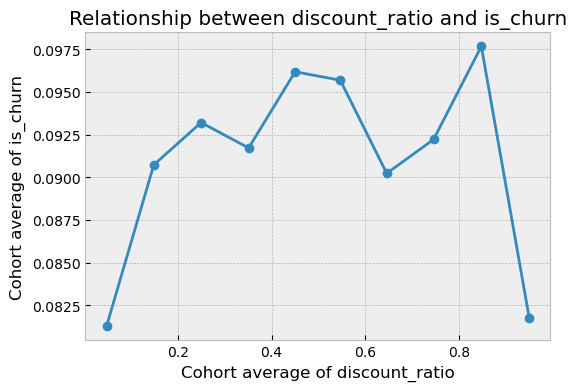

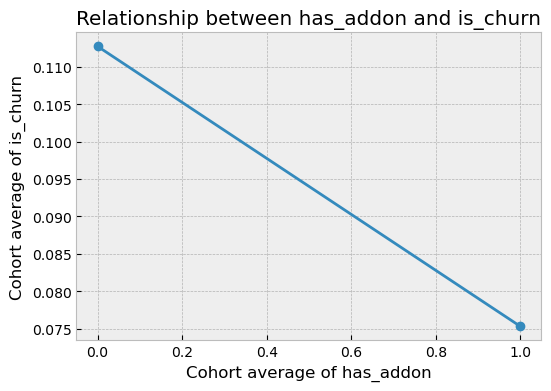

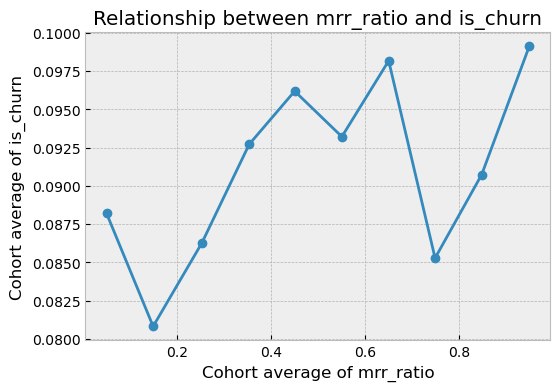

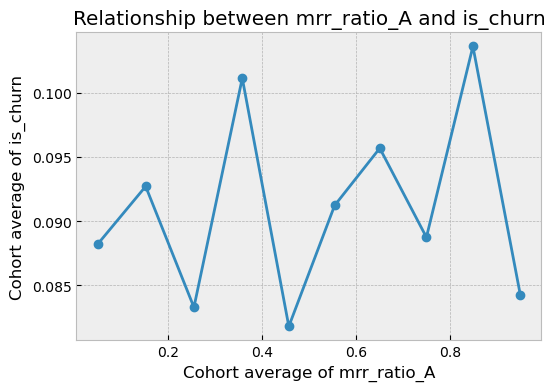

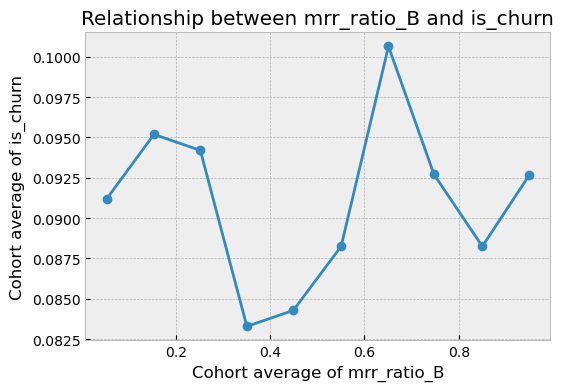

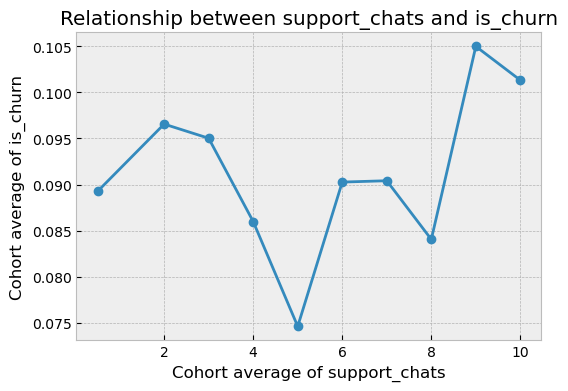

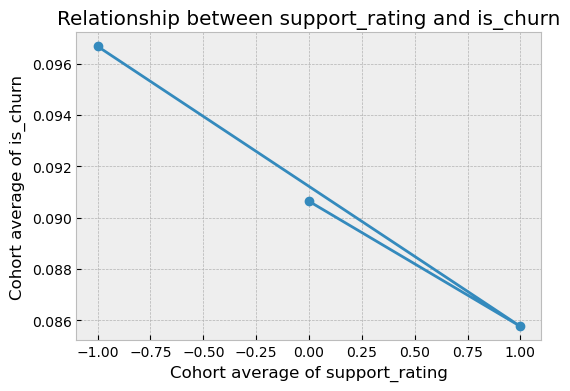

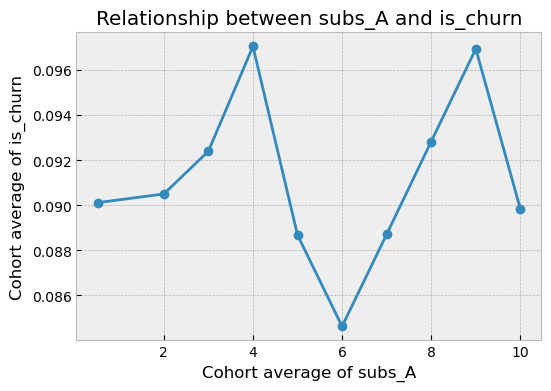

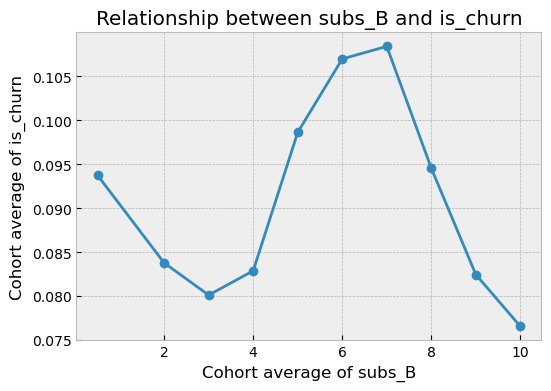

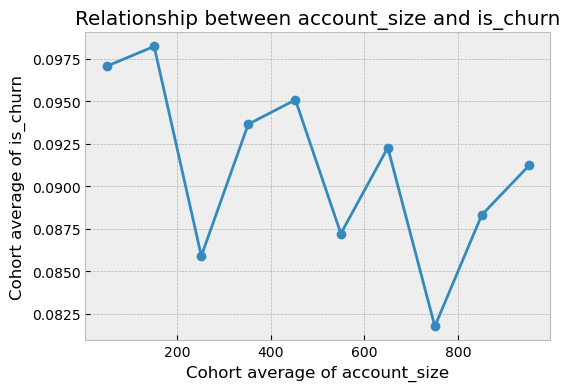

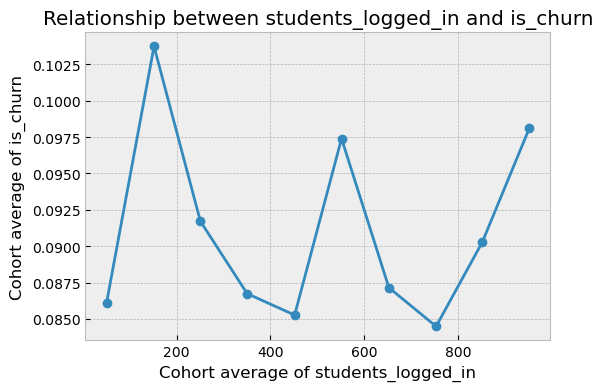

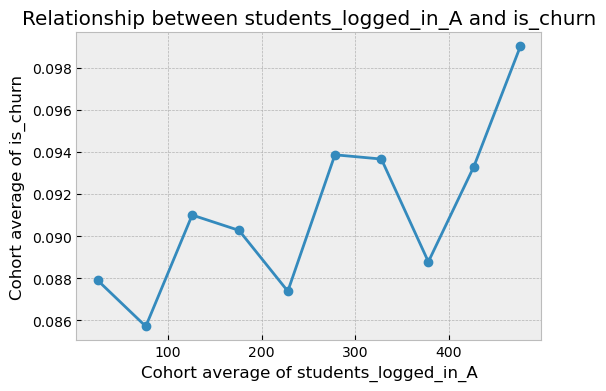

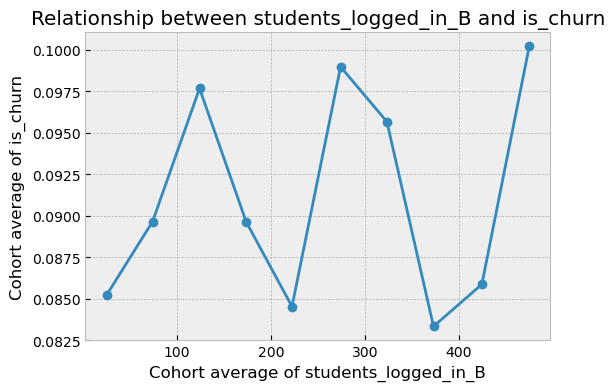

In [9]:
def cohort_plot(sourcedf, xmetric_name, ymetric_name, ncohort = 10, min_threshold = 5):
    # Cohorts are formed against xmetric and then means of each cohort is plotted for x and y metrics
    if len(sourcedf[xmetric_name].unique()) < min_threshold:
        cohort_xmeans = list(sourcedf[xmetric_name].unique())
        cohort_ymeans = sourcedf.groupby(xmetric_name)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans, ymetric_name: cohort_ymeans.values})
    else:
        groups = pd.qcut(sourcedf[xmetric_name], q=ncohort, duplicates = 'drop')
        cohort_xmeans = sourcedf.groupby(groups, observed=True)[xmetric_name].mean()
        cohort_ymeans = sourcedf.groupby(groups, observed=True)[ymetric_name].mean()
        df_to_plot = pd.DataFrame({xmetric_name: cohort_xmeans.values, ymetric_name: cohort_ymeans.values})
    
    plt.figure(figsize = (6,4))
    plt.plot(xmetric_name, ymetric_name, data = df_to_plot, marker = 'o', linewidth = 2)
    plt.xlabel('Cohort average of '+xmetric_name)
    plt.ylabel('Cohort average of '+ymetric_name)
    plt.grid(visible=True)
    plt.title("Relationship between "+xmetric_name+" and "+ymetric_name)


exclude_ = ['datetime64[ns]'] # data type to exclude from the analysis
cols_ = []
for i in range(0, len(churn_simulated_metrics.dtypes), 1):
    if (str(churn_simulated_metrics.dtypes.iloc[i]) not in exclude_) & (churn_simulated_metrics.columns[i] != 'is_churn'):
        cols_.append(churn_simulated_metrics.columns[i])

for col in cols_:
    cohort_plot(churn_simulated_metrics, col, 'is_churn', 10, 5)

## DATA SPLIT

In [11]:
churn_simulated_metrics['obs_date'] = pd.to_datetime(churn_simulated_metrics['obs_date'], format = '%Y-%m-%d')
churn_simulated_metrics.sort_values(by = 'obs_date', ascending = True, inplace = True)
churn_simulated_metrics.reset_index(inplace = True, drop = True)

# Prepare features and target labels
if 'has_addon' not in col_list:
    col_list = col_list+['has_addon']
X = np.array(churn_simulated_metrics.loc[:, col_list])
y = np.array(churn_simulated_metrics.loc[:, 'is_churn'])

# Time series split
tscv = TimeSeriesSplit(n_splits = 3)

## LOGISTIC REGRESSION

In [12]:
# Hyperparam selection
base_model = LogisticRegression(solver = 'liblinear')
test_par = {'C': [.005, .01, .04, .08, .16, .32, .64, .75, .95],
            'penalty' : ['l1','l2']          
           }
LR_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv = tscv, verbose = 1, n_jobs = -1)
LR_gsearch.fit(X,y)
LR_result_df = pd.DataFrame(LR_gsearch.cv_results_)

print(LR_gsearch.best_score_)
print(LR_gsearch.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
0.5528833926226339
{'C': 0.08, 'penalty': 'l1'}


## RANDOM FOREST

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0.5572468586063389
{'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}


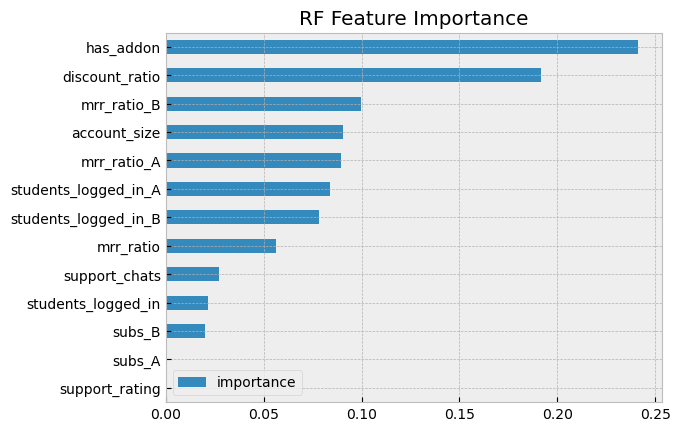

In [13]:
# Hyperparam selection
base_model = RandomForestClassifier(n_jobs = -1)
test_par = {'max_depth' : [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'n_estimators': [5,10,100,500,1000]}
RF_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
RF_gsearch.fit(X,y)
RF_result_df = pd.DataFrame(RF_gsearch.cv_results_)

print(RF_gsearch.best_score_)
print(RF_gsearch.best_params_)

# Check feature importance
X_feature = col_list
RF_feat = pd.DataFrame(data = RF_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'RF Feature Importance')
plt.show()

## XGBOOST

Fitting 3 folds for each of 300 candidates, totalling 900 fits
0.5578905850490697
{'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 0.05, 'n_estimators': 20}


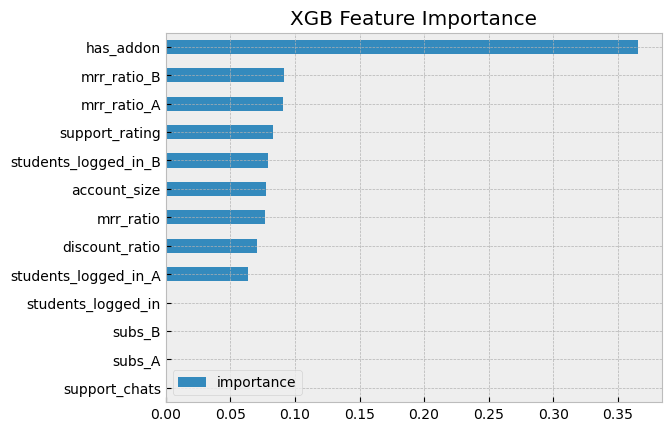

In [14]:
# Hyperparam selection
base_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs = -1, eval_metric = 'auc')
test_par = {'max_depth' : [2,10,20,25,40],
            'learning_rate': [.1,.2,.5],
            'n_estimators': [5,10,20,30,50],
            'min_child_weight': [.05,.15,.5,1]}
XGB_gsearch = GridSearchCV(base_model, param_grid = test_par, scoring = 'roc_auc', cv=tscv, verbose=1, n_jobs=-1, refit=True)
XGB_gsearch.fit(X,y)
XGB_result_df = pd.DataFrame(XGB_gsearch.cv_results_)

print(XGB_gsearch.best_score_)
print(XGB_gsearch.best_params_)

# Check feature importance
X_feature = col_list
RF_feat = pd.DataFrame(data = XGB_gsearch.best_estimator_.feature_importances_, index = X_feature, columns=['importance'])
RF_feat.sort_values('importance').plot(kind='barh', title = 'XGB Feature Importance')
plt.show()

## TEST SET UPLOAD

In [17]:
col_list = ['discount_ratio','mrr_ratio','mrr_ratio_A','mrr_ratio_B','support_chats', 'support_rating', 'subs_A','subs_B', 'account_size', 'students_logged_in', 'students_logged_in_A', 'students_logged_in_B']
col_list_full = ['obs_date', 'is_churn'] + col_list + ['has_addon']

_path = 'Test_simulated_data.xlsx'
test_set = pd.read_excel(_path, sheet_name = 'Sheet1')
test_set = test_set.astype({'is_churn':'int',
                            'discount_ratio':'float',
                            'mrr_ratio':'float',
                            'mrr_ratio_A':'float','mrr_ratio_B':'float',
                            'support_chats':'float',
                            'subs_A':'float','subs_B':'float',
                            'has_addon':'int'})
print(test_set.head(2))

# Prepare data for modelling
if 'has_addon' not in col_list:
    col_list = col_list+['has_addon']
X_test = np.array(test_set.loc[:, col_list])
y_test = np.array(test_set.loc[:, 'is_churn'])

print(X_test.shape)
print(y_test.shape)

  obs_date     is_churn  discount_ratio  mrr_ratio  mrr_ratio_A  mrr_ratio_B  \
0  2022-06-20  0        0.20            0.52       0.14         0.11           
1  2022-06-20  0        0.14            0.13       0.04         0.48           

   support_chats  support_rating  subs_A  subs_B  account_size  \
0 0.92           0.01            0.47    0.50    0.65            
1 0.22           0.03            0.56    0.63    0.06            

   students_logged_in  students_logged_in_A  students_logged_in_B  has_addon  
0 0.42                0.45                  0.16                   0          
1 0.63                0.83                  0.80                   0          
(678, 13)
(678,)


## MODEL PREDICTIONS

0.5567844028676343


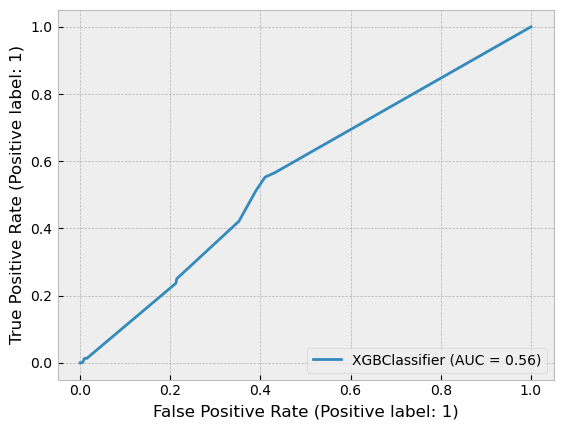

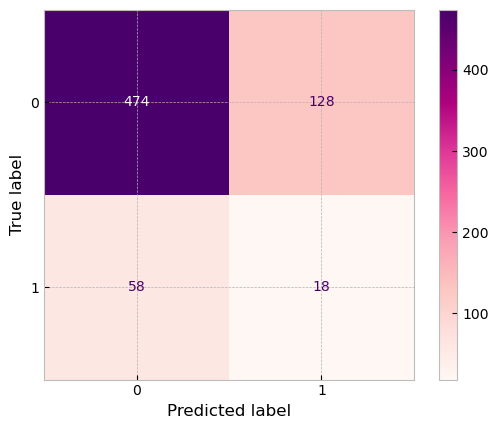

In [28]:
y_test_pred = XGB_gsearch.best_estimator_.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,y_test_pred))

metrics.RocCurveDisplay.from_estimator(XGB_gsearch.best_estimator_, X_test, y_test)
plt.show()

# Add predictions to the test set & calculate the confusion matrix
test_set['Predicted Churn Proba'] = y_test_pred

predicted_class = []
threshold = .16
for index, row in test_set.iterrows():
    if row['Predicted Churn Proba'] >= threshold:
        predicted_class.append(1)
    else:
        predicted_class.append(0)
        
test_set['Predicted Churn Class'] = predicted_class

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(test_set['is_churn'], test_set['Predicted Churn Class'], labels=XGB_gsearch.best_estimator_.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=XGB_gsearch.best_estimator_.classes_)
cm_display.plot(cmap='RdPu')
# print(test_set.sort_values(by=['Predicted Churn Proba','is_churn'], ascending = False).head(5))


plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_Format', '{:,.2f}'.format)
np.set_printoptions(suppress=True)